# Pitch mark estimation
This notebook runs through steps for accurately determining the location of pitch marks aligned to glottal (opening) instants from single-source speech data.

**Purpose**: to obtain very clean data for training prosodic models. This must be without gross errors (e.g. from pitch doubling/halving) and be accurate at the local level so that it can capture voice creakiness.

**Method overview**: 
1. Perform local autocorrelations
2. Turn these into pitch estimates (as a cleaned-up contour)
3. Use estimated pitch as a basis for ZFR pitch mark selection.

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Local pitch estimates
Use a PitchTracker to load audio and produce a of pitch estimates based on local autocorrelation.

Here just collate them all into lists to process offline.

In [65]:
import pitch.tracker as tracker

test_file = "../examples/test2.wav"

track = tracker.PitchTracker(40)
times, pitches, powers, voicing = zip(*track.track(test_file))

Tracked values are pitch and power over time. Time points are evenly spaced.

The local estimates after the single pass are:

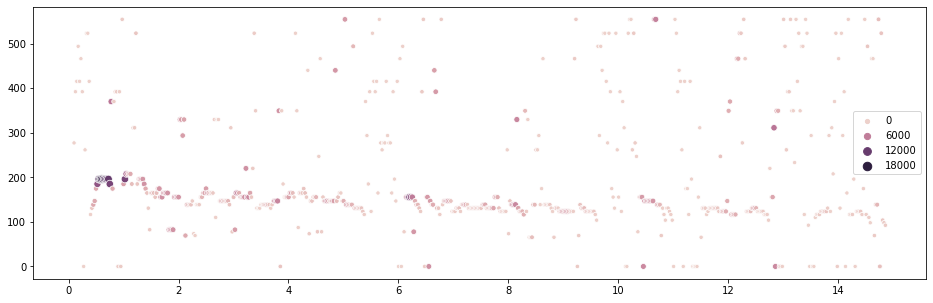

In [47]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x=times,y=pitches,size=powers,hue=powers)

## Pitch contour
Use a PitchContour (constructed from the time, pitch and power values) to clean up and smooth the pitch values.

The PitchContour object also provides interpolation for continuous addressing.

In [145]:
import pitch.contour as contour
pitch_copy = list(pitches)
cont = contour.PitchContour(times, pitch_copy, powers)

155.56  Hz
4921.831764705882  power


**Text output**: Average pitch (after weighting by power) and the 95th precentile power. 

The pitch contour will lie between half and double the average pitch. NOTE: this analysis isn't suitable for singing or other speech with high variation in pitch.

Internally, PitchContour values are still equally spaced in time. After cleanup they are:

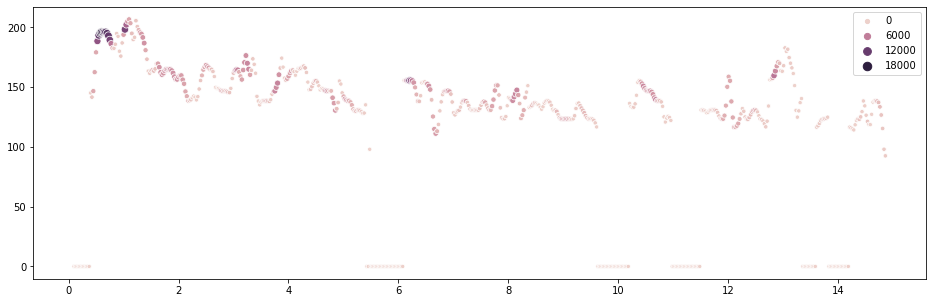

In [146]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x=cont.times,y=cont.pitch,size=cont.power,hue=cont.power)

## Pitch marks
Now search for the best glottal opening instants that match this contour. Actually finding the most significant increase in amplitude -- not strictly a glottal closure instant or glottal opening instant. So let's just call them pitch marks to stay on the safe side.

Method is ZFR, e.g. from: *Glottal opening instants detection using zero frequency resonator* Ramesh and Prasanna, IJST 2016

First reload the original speech data.

In [147]:
import scipy.io.wavfile as wavfile
sampling_rate, data = wavfile.read(test_file)

The ZFR approach wants to use 2-3 pitch periods as window size. The sole purpose of the PitchContour was to get reliable values for this. 

In [148]:
import glottal.instants as instants
frame_width = 40.0 / sampling_rate 
gis = instants.find_instants(data, cont, sampling_rate, frame_width*2)

0.4001360544217687 5.402403628117914 17646 238246
5.477437641723356 5.477437641723356 241555 241555
6.102721088435374 9.604308390022675 269130 423550
10.204580498866212 10.954920634920635 450021 483112
11.50517006802721 13.330997732426304 507377 587897
13.606122448979592 13.806213151927437 600030 608854
14.20639455782313 14.856689342403628 626502 655180


**Text output**: The voiced regions as start,end times then start,end indices.

The glottal instants are (sample,power) pairs, no longer evenly spaced, obviously.

Plotting power at each pitch mark:

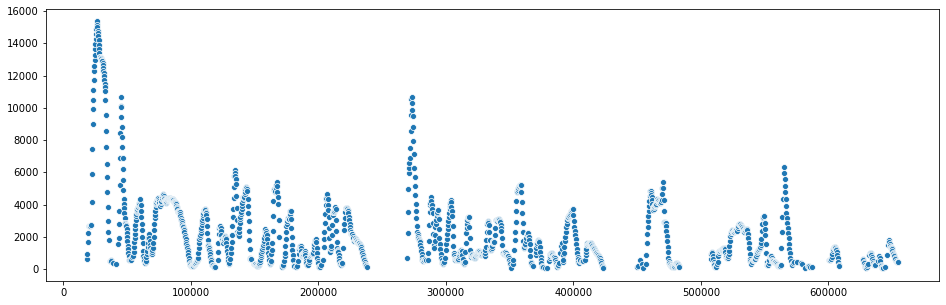

In [149]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x=[i[0] for i in gis],y=[i[1] for i in gis])

Plot these instants over the original wave to check positioning.

First with power on the y axis for the instants too (though it is harder to inspect their position):

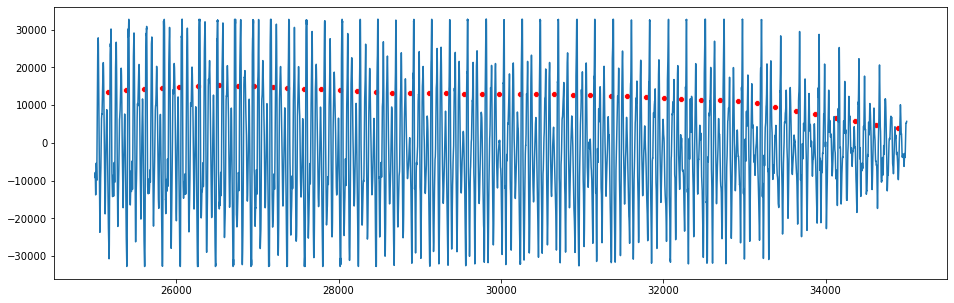

In [150]:
plt.figure(figsize=(16, 5))
start_index = 25000
end_index = 35000
ax = sns.lineplot(x=range(start_index,end_index),y=data[start_index:end_index])
instants = [i for i in gis if i[0] >= start_index and i[0] < end_index]
sns.scatterplot(x=[i[0] for i in instants],y=[i[1] for i in instants],color='red')

Looks fine.
## Further checks
Now check more closely, plus any likely locations of edge cases.

Now plot with y=0 for the instants -- easier to check their positioning.

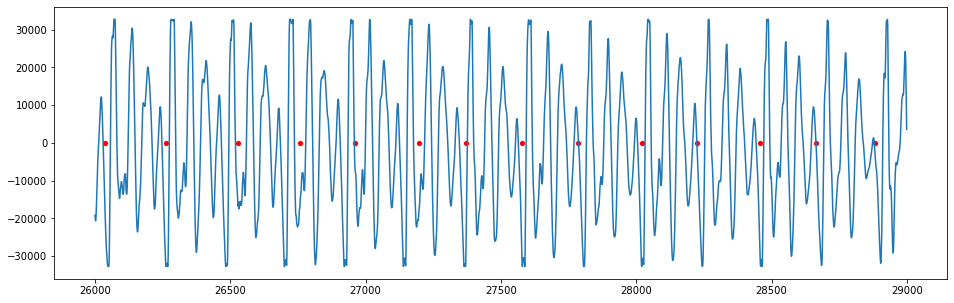

In [151]:
plt.figure(figsize=(16, 5))
start_index = 26000
end_index = 29000
sns.lineplot(x=range(start_index,end_index),y=data[start_index:end_index])
instants = [i for i in gis if i[0] >= start_index and i[0] < end_index]
sns.scatterplot(x=[i[0] for i in instants],y=[0 for i in instants],color='red')

Other features to inspect:
 - rapid changes in pitch
 - low power regions which may contain a creaky voice

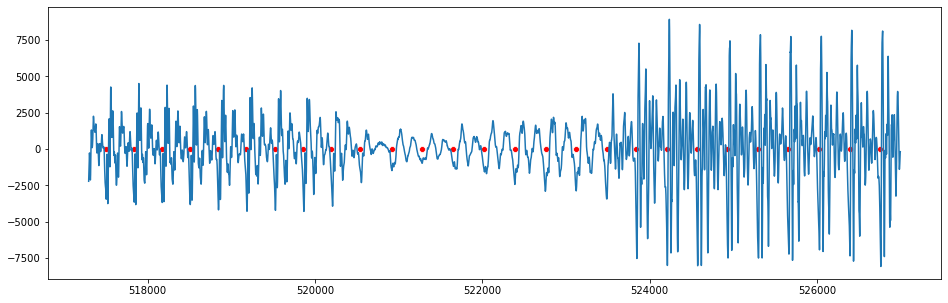

In [118]:
plt.figure(figsize=(16, 5))
start_index = int(11.73*44100)
end_index = int(11.95*44100)
sns.lineplot(x=range(start_index,end_index),y=data[start_index:end_index])
instants = [i for i in gis if i[0] >= start_index and i[0] < end_index]
sns.scatterplot(x=[i[0] for i in instants],y=[0 for i in instants],color='red')